<a href="https://colab.research.google.com/github/ElenaMorozzova/NLP_Intro/blob/main/NLP%20DZ8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Convolutional neural networks (CNN) vs recurrent neural networks (RNN) in NLP

LSTMs (Long Short Term Memory) are a special kind of RNN, capable of learning long-term dependencies which make RNN smart at remembering things that have happened in the past and finding patterns across time to make its next guesses make sense.

RNN pros: RNN captures the sequential information present in the input data i.e. dependency between the words in the text while making predictions. Better when classification is determined by a long range semantic

RNN cons: Deep RNNs suffer from the vanishing and exploding gradient problem which is a common problem in all the different types of neural networks.

CNN has several parallel filters which can be tuned to extract different features of interest.

CNN pros: good at extracting local and position-invariant features. Computation time CNN seems to be much faster (~ 5x ) than RNN

CNN cons: vanishing and exploding gradient problem

In [1]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv
Saving val.csv to val.csv


In [6]:
# !pip install stop_words
# !pip install pymorphy2

import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

#  df import
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_val = pd.read_csv("val.csv")

In [7]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [8]:
# Preprocessing
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [77]:
import numpy as np
import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, AveragePooling1D, SimpleRNN, LSTM, GRU, Masking, Flatten, add
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [19]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [20]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [21]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [23]:
import matplotlib.pyplot as plt

def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle('Horizontally stacked subplots')
       
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train', 'test'], loc='lower right')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train', 'test'], loc='lower right')

CNN with 1 Convolitional layer

In [24]:
dim = 30

inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=dim,
              trainable=True,
              mask_zero=True)(inputs)

x = Conv1D(128, 3, activation='relu')(x)

x = GlobalMaxPool1D()(x)
#x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)


model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 27)]              0         
                                                                 
 embedding (Embedding)       (None, 27, 30)            7743240   
                                                                 
 conv1d (Conv1D)             (None, 25, 128)           11648     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                             

Epoch 1/15
709/709 [==============================] - 42s 58ms/step - loss: 0.5402 - accuracy: 0.7165 - val_loss: 0.5074 - val_accuracy: 0.7477
Epoch 2/15
709/709 [==============================] - 41s 58ms/step - loss: 0.2894 - accuracy: 0.8816 - val_loss: 0.5992 - val_accuracy: 0.7396
Epoch 3/15
709/709 [==============================] - 41s 58ms/step - loss: 0.1036 - accuracy: 0.9637 - val_loss: 0.7754 - val_accuracy: 0.7289
Epoch 4/15
709/709 [==============================] - 40s 57ms/step - loss: 0.0426 - accuracy: 0.9858 - val_loss: 1.0427 - val_accuracy: 0.7227


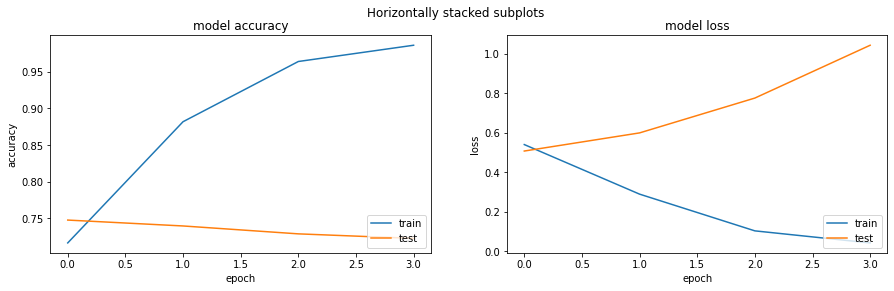

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=256, epochs=15, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=True)

plot_history(history)

In [32]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 1s 2ms/step - loss: 0.5074 - accuracy: 0.7477


[0.5074216723442078, 0.7476524114608765]

"LeNet-5 like" CNN Architecture

In [39]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=dim,
              trainable=True,
              mask_zero=True)(inputs)

x = Conv1D(128, 3, activation='relu')(x)
x = AveragePooling1D()(x)

x = Conv1D(160, 3, activation='relu')(x)
x = AveragePooling1D()(x)

x = Flatten()(x)

x = Dense(120, activation='relu')(x)
x = Dense(84, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 27)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 27, 30)            7743240   
                                                                 
 conv1d_4 (Conv1D)           (None, 25, 128)           11648     
                                                                 
 average_pooling1d_2 (Averag  (None, 12, 128)          0         
 ePooling1D)                                                     
                                                                 
 conv1d_5 (Conv1D)           (None, 10, 160)           61600     
                                                                 
 average_pooling1d_3 (Averag  (None, 5, 160)           0         
 ePooling1D)                                               

Epoch 1/15
709/709 [==============================] - 57s 79ms/step - loss: 0.5672 - accuracy: 0.6956 - val_loss: 0.5624 - val_accuracy: 0.7113
Epoch 2/15
709/709 [==============================] - 56s 79ms/step - loss: 0.3103 - accuracy: 0.8680 - val_loss: 0.6436 - val_accuracy: 0.7006
Epoch 3/15
709/709 [==============================] - 56s 78ms/step - loss: 0.1357 - accuracy: 0.9470 - val_loss: 0.8730 - val_accuracy: 0.6915
Epoch 4/15
709/709 [==============================] - 56s 79ms/step - loss: 0.0707 - accuracy: 0.9723 - val_loss: 1.0810 - val_accuracy: 0.6847


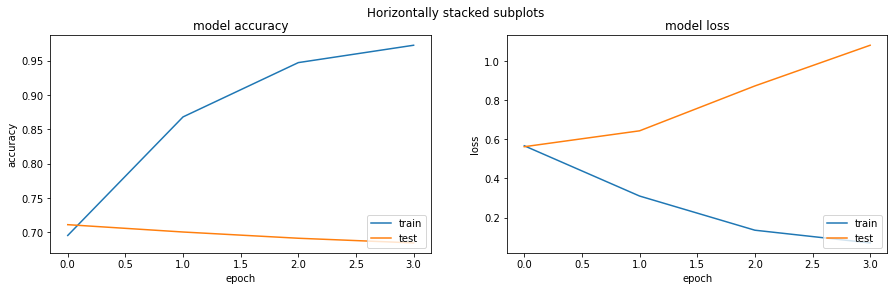

In [40]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=256, epochs=15, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=True)

plot_history(history)

In [41]:
# Accuracy is lower than in CNN-1
model.evaluate(X_valid, y_val)

709/709 [==============================] - 2s 3ms/step - loss: 0.5624 - accuracy: 0.7113


[0.5624372363090515, 0.7112815976142883]

LSTM with 1 LSTM layer

In [42]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = LSTM(64, recurrent_dropout=0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 27)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 27, 30)            7743240   
                                                                 
 lstm (LSTM)                 (None, 64)                24320     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,771,785
Trainable params: 7,771,785
Non-tra

Epoch 1/15
709/709 [==============================] - 78s 107ms/step - loss: 0.5327 - accuracy: 0.7257 - val_loss: 0.5015 - val_accuracy: 0.7516
Epoch 2/15
709/709 [==============================] - 77s 109ms/step - loss: 0.2908 - accuracy: 0.8802 - val_loss: 0.5908 - val_accuracy: 0.7375
Epoch 3/15
709/709 [==============================] - 76s 108ms/step - loss: 0.1425 - accuracy: 0.9451 - val_loss: 0.7555 - val_accuracy: 0.7297
Epoch 4/15
709/709 [==============================] - 76s 108ms/step - loss: 0.0867 - accuracy: 0.9672 - val_loss: 0.9612 - val_accuracy: 0.7233


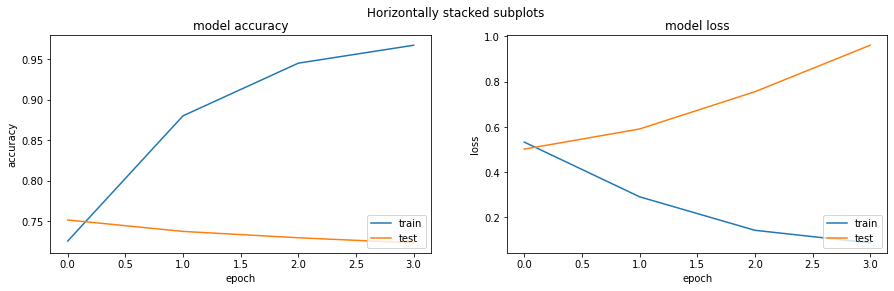

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=256, epochs=15, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=True)

plot_history(history)

In [44]:
# Accuracy is little higher than was in CNN-1 architecture, but longer time to train
model.evaluate(X_valid, y_val)

709/709 [==============================] - 4s 5ms/step - loss: 0.5015 - accuracy: 0.7516


[0.5014968514442444, 0.7516201734542847]

LSTM with 3 LSTM layers

In [48]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

lstm = LSTM(30, recurrent_dropout=0.2)(x)
x = add([x, lstm])

lstm = LSTM(30, recurrent_dropout=0.2)(x)
x = add([x, lstm])

lstm = LSTM(30, recurrent_dropout=0.2)(x)
x = add([x, lstm])
x = Flatten()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [49]:
model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 27)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 27, 30)       7743240     ['input_9[0][0]']                
                                                                                                  
 lstm_3 (LSTM)                  (None, 30)           7320        ['embedding_8[0][0]']            
                                                                                                  
 add_1 (Add)                    (None, 27, 30)       0           ['embedding_8[0][0]',            
                                                                  'lstm_3[0][0]']           

Epoch 1/15
709/709 [==============================] - 119s 159ms/step - loss: 0.5284 - accuracy: 0.7280 - val_loss: 0.5079 - val_accuracy: 0.7472
Epoch 2/15
709/709 [==============================] - 118s 166ms/step - loss: 0.2696 - accuracy: 0.8899 - val_loss: 0.6191 - val_accuracy: 0.7409
Epoch 3/15
709/709 [==============================] - 116s 164ms/step - loss: 0.1166 - accuracy: 0.9561 - val_loss: 0.7492 - val_accuracy: 0.7279
Epoch 4/15
709/709 [==============================] - 116s 164ms/step - loss: 0.0671 - accuracy: 0.9748 - val_loss: 0.9692 - val_accuracy: 0.7227


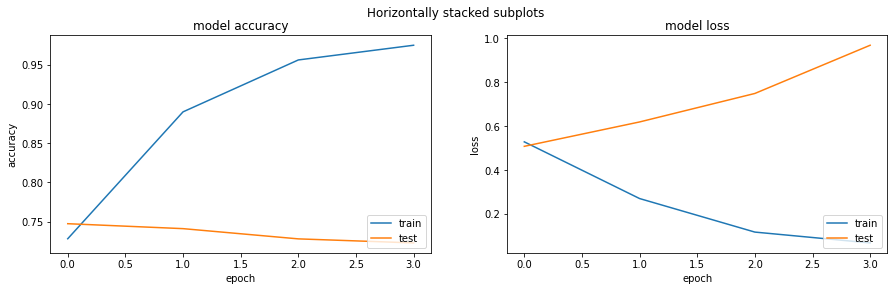

In [50]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=256, epochs=15, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=True)

plot_history(history)

In [51]:
# Accuracy is similar to CNN-1, much longer time for model training
model.evaluate(X_valid, y_val)

709/709 [==============================] - 8s 12ms/step - loss: 0.5079 - accuracy: 0.7472


[0.5078989267349243, 0.7472115755081177]

LSTM + CNN Model (combination of different layers types per better accuracy)

In [66]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = LSTM(64, return_sequences=True)(x)
x = (Conv1D(64, kernel_size=3, activation='relu', padding="same"))(x)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [67]:
model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 27)]              0         
                                                                 
 embedding_23 (Embedding)    (None, 27, 30)            7743240   
                                                                 
 lstm_17 (LSTM)              (None, 27, 64)            24320     
                                                                 
 conv1d_19 (Conv1D)          (None, 27, 64)            12352     
                                                                 
 global_max_pooling1d_11 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_11 (Flatten)        (None, 64)                0         
                                                           

Epoch 1/15
709/709 [==============================] - 83s 113ms/step - loss: 0.5321 - accuracy: 0.7236 - val_loss: 0.5039 - val_accuracy: 0.7486
Epoch 2/15
709/709 [==============================] - 78s 110ms/step - loss: 0.2796 - accuracy: 0.8859 - val_loss: 0.6130 - val_accuracy: 0.7384
Epoch 3/15
709/709 [==============================] - 78s 110ms/step - loss: 0.1216 - accuracy: 0.9551 - val_loss: 0.7993 - val_accuracy: 0.7337
Epoch 4/15
709/709 [==============================] - 78s 110ms/step - loss: 0.0671 - accuracy: 0.9760 - val_loss: 1.0283 - val_accuracy: 0.7255


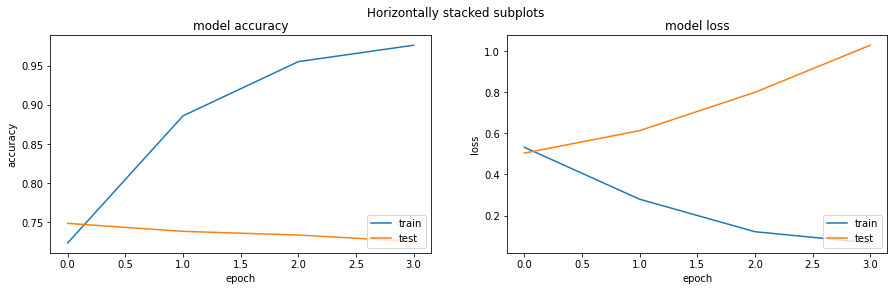

In [68]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=256, epochs=15, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=True)

plot_history(history)

In [69]:
# Accuracy is similar to CNN-1, longer time for model training
model.evaluate(X_valid, y_val)

709/709 [==============================] - 5s 7ms/step - loss: 0.5039 - accuracy: 0.7486


[0.5038946270942688, 0.7485782504081726]

In [73]:
# Same without MaxPool layer
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = LSTM(64, return_sequences=True)(x)
x = (Conv1D(64, kernel_size=3, activation='relu', padding="same"))(x)
# x = GlobalMaxPool1D()(x)
x = Flatten()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [74]:
model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 27)]              0         
                                                                 
 embedding_27 (Embedding)    (None, 27, 30)            7743240   
                                                                 
 lstm_21 (LSTM)              (None, 27, 64)            24320     
                                                                 
 conv1d_23 (Conv1D)          (None, 27, 64)            12352     
                                                                 
 flatten_15 (Flatten)        (None, 1728)              0         
                                                                 
 dense_19 (Dense)            (None, 64)                110656    
                                                                 
 dropout_8 (Dropout)         (None, 64)                0   

Epoch 1/15
709/709 [==============================] - 84s 113ms/step - loss: 0.5343 - accuracy: 0.7230 - val_loss: 0.5126 - val_accuracy: 0.7493
Epoch 2/15
709/709 [==============================] - 80s 112ms/step - loss: 0.2856 - accuracy: 0.8827 - val_loss: 0.5954 - val_accuracy: 0.7407
Epoch 3/15
709/709 [==============================] - 79s 112ms/step - loss: 0.1308 - accuracy: 0.9508 - val_loss: 0.7733 - val_accuracy: 0.7317
Epoch 4/15
709/709 [==============================] - 79s 112ms/step - loss: 0.0721 - accuracy: 0.9736 - val_loss: 0.9641 - val_accuracy: 0.7272


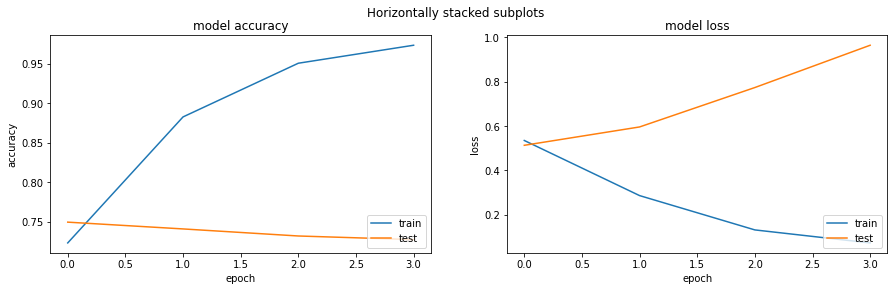

In [75]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=256, epochs=15, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=True)

plot_history(history)

In [76]:
# No visible change in accuracy value
model.evaluate(X_valid, y_val)

709/709 [==============================] - 5s 7ms/step - loss: 0.5126 - accuracy: 0.7493


[0.5126218199729919, 0.7492836117744446]

GRU-CNN hybrid model (combines the gated recurrent unit (GRU) and CNN)


the feature vector of time sequence data is extracted by the GRU module, and the feature vector of other high-dimensional data is extracted by the CNN module.

In [81]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = GRU(64, return_sequences=True)(x)
x = (Conv1D(64, kernel_size=3, activation='relu', padding="same"))(x)
# x = GlobalMaxPool1D()(x)
x = Flatten()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [82]:
model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 27)]              0         
                                                                 
 embedding_31 (Embedding)    (None, 27, 30)            7743240   
                                                                 
 gru (GRU)                   (None, 27, 64)            18432     
                                                                 
 conv1d_27 (Conv1D)          (None, 27, 64)            12352     
                                                                 
 flatten_16 (Flatten)        (None, 1728)              0         
                                                                 
 dense_21 (Dense)            (None, 64)                110656    
                                                                 
 dropout_9 (Dropout)         (None, 64)                0   

Epoch 1/15
709/709 [==============================] - 76s 102ms/step - loss: 0.5301 - accuracy: 0.7271 - val_loss: 0.4971 - val_accuracy: 0.7527
Epoch 2/15
709/709 [==============================] - 71s 100ms/step - loss: 0.2789 - accuracy: 0.8848 - val_loss: 0.6152 - val_accuracy: 0.7407
Epoch 3/15
709/709 [==============================] - 71s 100ms/step - loss: 0.1197 - accuracy: 0.9555 - val_loss: 0.8165 - val_accuracy: 0.7340
Epoch 4/15
709/709 [==============================] - 71s 100ms/step - loss: 0.0624 - accuracy: 0.9772 - val_loss: 1.0943 - val_accuracy: 0.7263


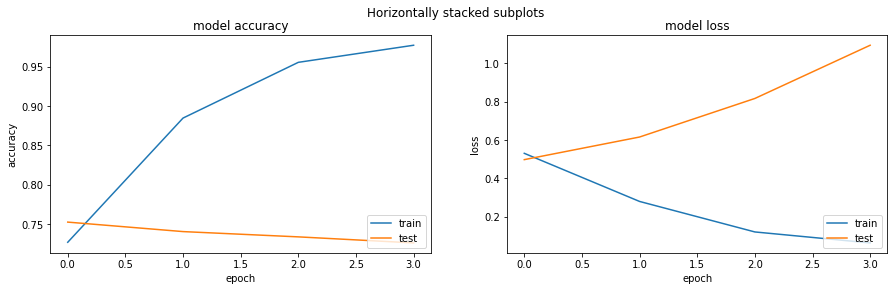

In [83]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=256, epochs=15, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=True)

plot_history(history)

In [84]:
# A bit higher accuracy vs LSTM hybrid
model.evaluate(X_valid, y_val)

709/709 [==============================] - 5s 7ms/step - loss: 0.4971 - accuracy: 0.7527


[0.4971150755882263, 0.7527223229408264]

Accuracy rate results:

1. GRU-CNN 
2. LSTM with 1 LSTM layer
3. LSTM + CNN without MaxPool layer